<a href="https://colab.research.google.com/github/yahui624/DeployTFModels-FL/blob/main/deployModel_TFServing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import json 
import requests 
import numpy as np
from pathlib import Path
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis.predict_pb2 import PredictRequest

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(X_train.shape)
print(X_train.dtype)

(55000, 28, 28)
uint8


In [ ]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers

In [ ]:
hidden1 = model.layers[1]
print(hidden1.name)
print(model.get_layer('dense') is hidden1)

dense
True


In [ ]:
weights, biases = hidden1.get_weights()
print(weights)
print(weights.shape)

[[ 0.06058672 -0.06986862  0.04433709 ... -0.04933327 -0.0634008
  -0.02074547]
 [-0.00800362  0.00011741 -0.03689461 ...  0.0141236   0.04465593
   0.06361842]
 [ 0.00606163 -0.01368931  0.0369891  ... -0.02546292  0.05863243
   0.05439176]
 ...
 [-0.03656948  0.04936408 -0.04137322 ...  0.0005776   0.06820166
  -0.029804  ]
 [ 0.02403316  0.0388655  -0.05839512 ... -0.02298842  0.00356434
   0.04367478]
 [-0.04125248  0.02786408  0.04889874 ... -0.00300227 -0.02756291
   0.0566586 ]]
(784, 300)


In [ ]:
print(biases)
print(biases.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(300,)


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7110 - accuracy: 0.7639 - val_loss: 0.5171 - val_accuracy: 0.8132
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4882 - accuracy: 0.8308 - val_loss: 0.4518 - val_accuracy: 0.8402
Epoch 3/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4423 - accuracy: 0.8465 - val_loss: 0.4267 - val_accuracy: 0.8476
Epoch 4/30
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4148 - accuracy: 0.8552 - val_loss: 0.4358 - val_accuracy: 0.8510
Epoch 5/30
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3962 - accuracy: 0.8617 - val_loss: 0.4237 - val_accuracy: 0.8574
Epoch 6/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3787 - accuracy: 0.8685 - val_loss: 0.3821 - val_accuracy: 0.8660
Epoch 7/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3658 - accuracy: 0.8717 - val_loss: 0.3942 - val_accu

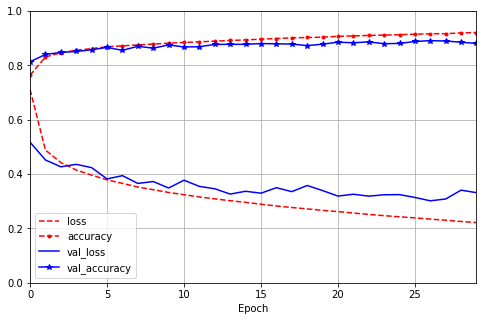

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3444 - accuracy: 0.8770


[0.34435731172561646, 0.8769999742507935]

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 91ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [ ]:
y_pred = y_proba.argmax(axis=-1)
print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


In [ ]:
y_new = y_test[:3]
print(y_new)

[9 2 1]


In [ ]:
# Exporting SavedModels
model_name = "my_mnist_model"
model_version = "0001"
model_path = Path(model_name) / model_version
model.save(model_path, save_format="tf")

In [ ]:
loaded = tf.saved_model.load(model_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [ ]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'dense_2': TensorSpec(shape=(None, 10), dtype=tf.float32, name='dense_2')}


In [ ]:
!saved_model_cli show --dir my_mnist_model/0001

The given SavedModel contains the following tag-sets:
'serve'


In [ ]:
!saved_model_cli show --dir my_mnist_model/0001 --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


In [ ]:
! saved_model_cli show --dir my_mnist_model/0001 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['flatten_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28)
      name: serving_default_flatten_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_2'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
!saved_model_cli show --dir {model_path} --all # saved model 

2022-12-02 04:30:28.120848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-02 04:30:28.121279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-02 04:30:28.121317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op

In [ ]:
# Install and start TF Serving 
url = "https://storage.googleapis.com/tensorflow-serving-apt"
src = "stable tensorflow-model-server tensorflow-model-server-universal"
!echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
!curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
!apt update -q && apt-get install -y tensorflow-model-server
%pip install -q -U tensorflow-serving-api

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  14641      0 --:--:-- --:--:-- --:--:-- 14641
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [1,039 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic

In [ ]:
os.environ["MODEL_DIR"] = str(model_path.parent.absolute())

In [ ]:
%%bash --bg
tensorflow_model_server \
     --port=8500 \
     --rest_api_port=8501 \
     --model_name=my_mnist_model \
     --model_base_path="${MODEL_DIR}" >my_server.log 2>&1

In [ ]:
# Query TF serving 
X_new = X_test[:3]  # pretend we have 3 new digit images to classify
request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X_new.tolist(),
})

In [ ]:
# POST REST request to TF Serving
server_url = "http://localhost:8501/v1/models/my_mnist_model:predict"
response = requests.post(server_url, data=request_json)
response.raise_for_status()  # raise an exception in case of error
response = response.json()

ConnectionError: ignored

In [ ]:
y_proba = np.array(response["predictions"])
y_proba.round(2)

In [ ]:
# Query TF serving through gRPC API
request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = "serving_default"
input_name = model.input_names[0]  # == "flatten_input"
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(X_new))

In [ ]:
channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

In [ ]:
output_name = model.output_names[0]  # == "dense_1"
outputs_proto = response.outputs[output_name]
y_proba = tf.make_ndarray(outputs_proto)